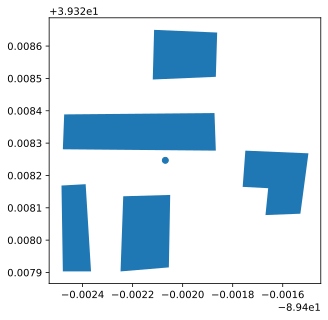

In [5]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import time
import h5pyd
import geopandas as gpd
import matplotlib.pyplot as plt

import os

#from dw_tap.process_geojson import get_obstacles
from dw_tap.data_fetching import getData
#from dw_tap.process_geojson import get_candidate
from dw_tap.lom import run_lom
from dw_tap.power_output import estimate_power_output
from dw_tap.vector.vector_transformation import _convert_to_math_deg
from dw_tap.heatmap import gen_heatmap_points

import shapely.wkt
import matplotlib.pyplot as plt

import plotly.express as px

%config InlineBackend.figure_format = 'svg'

obstacle_file ="../sites/180-5BuildingsManual.geojson"

#obstacle_file ="../sites/180-3dBuildings1.geojson"


df_places = gpd.read_file(obstacle_file)
# Leave in only relevant columns
df_places = df_places[["height", "geometry"]]

df_places["height"] = 5.0

ax=df_places.geometry.plot()

# Need to use better projection
# source of solution: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
df_places_centroid = df_places.dissolve().to_crs('+proj=cea').centroid.to_crs(df_places.crs)
df_places_centroid.geometry.plot(ax=ax);

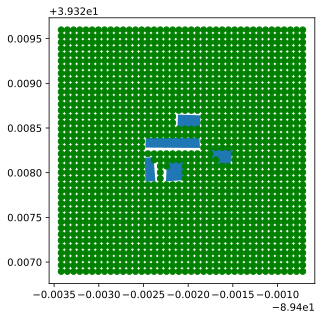

In [12]:
n_points = 40
gridpoints = gen_heatmap_points(df_places, n_points=n_points,
                                visualize=True, file_dest="./heatmap-grid-180.json")

In [13]:
# For testing outside of NREL, load in data from a file
# This isn't quite the same as running getData() for each of the heatmap points
# (because spatial interpolation will change the values slighly)
# but it is close enough for the first pass
atmospheric_df = pd.read_csv("../data/180_heatmap_atmospheric_df.csv")

# Limit the input
atmospheric_df = atmospheric_df[:24*30*3]

atmospheric_df

,datetime,ws,wd,temp,pres
0,2007-01-01 00:00:00,7.683119,232.508191,282.541870,98499.850352
1,2007-01-01 01:00:00,8.222278,238.574261,281.693481,98501.451630
2,2007-01-01 02:00:00,6.988345,231.297383,280.445251,98545.683064
3,2007-01-01 03:00:00,8.520537,237.966652,279.526672,98557.756792
4,2007-01-01 04:00:00,8.442824,237.396860,278.693512,98561.814434
...,...,...,...,...,...
2155,2007-03-31 19:00:00,9.203378,172.506519,295.564148,98661.635991
2156,2007-03-31 20:00:00,12.385622,169.945872,296.003601,98576.918224
2157,2007-03-31 21:00:00,13.704353,174.381295,295.783875,98519.226515
2158,2007-03-31 22:00:00,12.118584,168.954374,295.365753,98405.985912


### Below: heatmap for a specific moment in time and showing ws-adjusted (wind estimate after LOM)

In [14]:
# Select indecies for studying (each index corresponds to a timestep in the input atmospheric dataframe)
# Maybe start with a list with a single value and then try a longer list
time_step_ids = [5, 300, 500, 1500, 2000, 5000]

# Along the selected, leave in the ones that will not cause issues: between 0 and length of atmospheric_df
time_step_ids = [id for id in time_step_ids if ((id >= 0) and (id < len(atmospheric_df)))]
time_step_ids

[5, 300, 500, 1500, 2000]

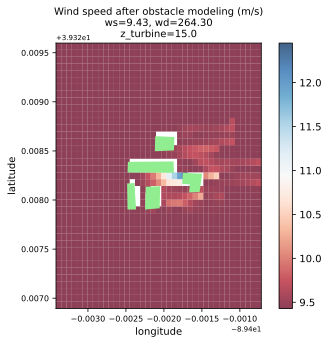

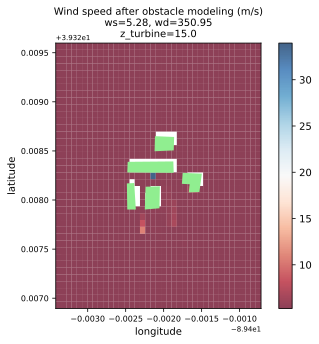

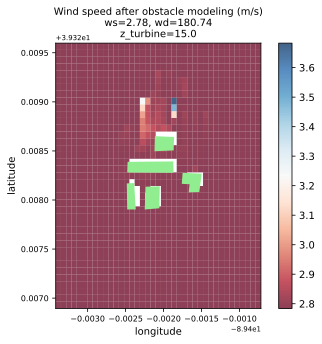

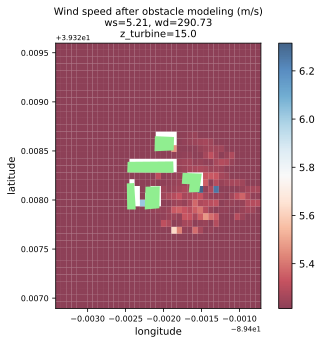

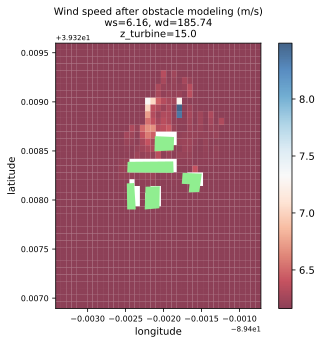

In [16]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

z_turbine = 15  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    # iterate over gridspoints outside of obstacles
    for idx in gridpoints.index:

        if gridpoints.at[idx, "obstacleRel"] == "inside":
            predicted_ws = np.NaN
            summary_df.loc[len(summary_df)] = [gridpoints.at[idx, "geometry"], predicted_ws]
        else:
            lat, lon = gridpoints.at[idx, "geometry"].y, gridpoints.at[idx, "geometry"].x

            lat_lon_label = str(lat) + "_" + str(lon)
            #print(lat_lon_label)

            ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
            #print(ts_df_path)

            time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])


            xy_turbine = [np.array([lon, lat])]

            # Instead of passing an entire input dataframe, here we pass in a single row
            predictions_df = \
                run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                       check_distance=True)

            predicted_ws = predictions_df.at[0, "ws-adjusted"]
            summary_df.loc[len(summary_df)] = [gridpoints.at[idx, "geometry"], 
                                              predicted_ws]

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z[~np.isnan(z)].min(), z[~np.isnan(z)].max()
    fig, ax = plt.subplots()
    ax.tick_params(axis='both', which='major', labelsize=8)
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]

    ax.set_title('Wind speed after obstacle modeling (m/s)\nws=%.2f, wd=%.2f\nz_turbine=%.1f' % (input_ws, input_wd, z_turbine), fontsize=10)
    ax.set_aspect('equal')
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    t = ax.yaxis.get_offset_text()
    t.set_size(7)
    t = ax.xaxis.get_offset_text()
    t.set_size(7)

    plt.show()

### Below: heatmap vis for energy produced over entire studied period 

In [17]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine = 20   
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

summary_df_cols = ["geometry", "time_period", 
                   "khw_without_lom", "khw_with_lom", "kwh_delta", 
                   "ts_file_path"]
summary_df = pd.DataFrame(columns=summary_df_cols)
summary_df_path = os.path.join(output_dest, "summary.csv")

if os.path.exists(summary_df_path):
    if not overwrite:
        summary_df = pd.read_csv(summary_df_path)

# For testing outside of NREL, load in data from a file
# This isn't quite the same as running getData() for each of the heatmap points
# (because spatial interpolation will change the values slighly)
# but it is close enough for the first pass

atmospheric_df = pd.read_csv("../data/180_heatmap_atmospheric_df.csv") 
time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

# iterate over gridspoints outside of obstacles
for idx in gridpoints.index:

    if gridpoints.at[idx, "obstacleRel"] == "inside":
        summary_df.loc[len(summary_df)] = [gridpoints.at[idx, "geometry"], time_period, 0, 0, 0, '']
    else:
    
        lat, lon = gridpoints.at[idx, "geometry"].y, gridpoints.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        # atmospheric_df = getData(f, 
        #                          lat, 
        #                          lon, 
        #                          z_turbine, "IDW", True, 
        #                          start_time_idx=0, end_time_idx=4000, time_stride=1) # 0, 4380, 1) # year: 8760; Quick test: 0, 2000, 200)

        # For testing outside of NREL, load in data from a file
        # This isn't quite the same as running getData() for each of the heatmap points
        # (because spatial interpolation will change the values slighly)
        # but it is close enough for the first pass

        # atmospheric_df.to_csv("../data/180_heatmap_atmospheric_df.csv", index=False)
        # break 

        # print("Done with data fetching for the point.")

        xy_turbine = [np.array([lon, lat])]

        predictions_df = \
            run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        avg_ws_delta = (predictions_df["ws"] - predictions_df["ws-adjusted"]).mean()
        print("Current point: (%.5f, %.5f); avg. ws deficit (m/s): %.6f" % (lat, lon, avg_ws_delta))

        time_powerOutput0 = time.time()

        kw_ts_with_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
            estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                                  ws_column="ws-adjusted")  
        kwh_total_with_lom = kw_ts_with_lom.sum()

        kw_ts_without_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
            estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                                  ws_column="ws")  
        kwh_total_without_lom = kw_ts_without_lom.sum()


        summary_df.loc[len(summary_df)] = [gridpoints.at[idx, "geometry"],
                                           time_period,
                                           kwh_total_without_lom,
                                           kwh_total_with_lom,
                                           kwh_total_without_lom - kwh_total_with_lom,
                                           ts_df_path]

        ts_df = pd.DataFrame({"datetime": atmospheric_df["datetime"],
                              "ws": atmospheric_df["ws"],
                              "wd": atmospheric_df["wd"],
                              "ws-adjusted": predictions_df["ws-adjusted"],
                              "kw_ts_without_lom": kw_ts_without_lom,
                              "kw_ts_with_lom": kw_ts_with_lom})

        summary_df.to_csv(summary_df_path, index=False)
        #ts_df.to_csv(ts_df_path, index=False)
                                           
    #break

Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.403); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.402); avg. ws deficit (m/s): 0.000
Current point: (39.327, -89.402); avg. ws deficit (m/s)

In [18]:
summary_df

,geometry,time_period,khw_without_lom,khw_with_lom,kwh_delta,ts_file_path
0,POINT (-89.40342060519043 39.32689540174526),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32689540174526_-89.40...
1,POINT (-89.40335130512113 39.32689540174526),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32689540174526_-89.40...
2,POINT (-89.40328200505184 39.32689540174526),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32689540174526_-89.40...
3,POINT (-89.40321270498254 39.32689540174526),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32689540174526_-89.40...
4,POINT (-89.40314340491324 39.32689540174526),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32689540174526_-89.40...
...,...,...,...,...,...,...
1595,POINT (-89.40099510276494 39.32959810444797),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32959810444797_-89.40...
1596,POINT (-89.40092580269564 39.32959810444797),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32959810444797_-89.40...
1597,POINT (-89.40085650262634 39.32959810444797),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32959810444797_-89.40...
1598,POINT (-89.40078720255704 39.32959810444797),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32959810444797_-89.40...


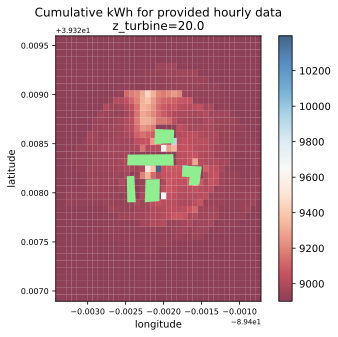

In [19]:
# Energy estimates: visualize as a heatmap

# Convert strings (possibly loaded from saved file) to shapely point objects
for idx in summary_df.index:
    el = summary_df["geometry"][idx]
    if type(el) == type("string"):
        summary_df["geometry"][idx] = shapely.wkt.loads(el)

# following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.khw_with_lom.tolist()

# generate 2 2d grids for the x & y bounds
y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)

z = np.array(z_).reshape(n_points,-1)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = z[z>0].min(), z[z>0].max()

fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=8)
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)
ax.set_title('Cumulative kWh for provided hourly data\nz_turbine=%.1f' % z_turbine)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

df_places.geometry.plot(color='lightgreen', ax=ax)
t = ax.yaxis.get_offset_text()
t.set_size(7)
t = ax.xaxis.get_offset_text()
t.set_size(7)

plt.show()

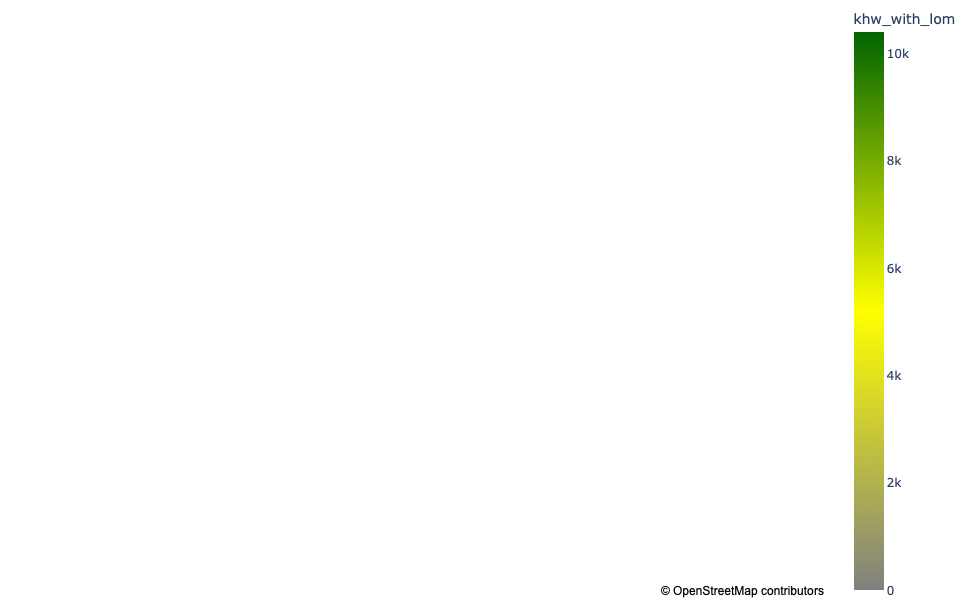

In [22]:
# Different, interactive visualization

# Based on: https://stackoverflow.com/questions/68946831/draw-a-polygon-around-point-in-scattermapbox-using-python

import plotly.graph_objects as go

obstacle_layer = []
for idx in df_places.index:
    p = df_places.iloc[idx].geometry
    obstacle_layer.append({
            'source': {
                'type': "FeatureCollection",
                'features': [{
                    'type': "Feature",
                    'geometry': {
                        'type': "MultiPolygon",
                        'coordinates': 
                        [[[[coords[0], coords[1]] for coords in p.exterior.coords]]]
                    }
                }]},
            'type': "fill", 'below': "traces", 'color': "royalblue"
            })


df_for_vis = pd.DataFrame({"lon": [el.x for el in summary_df.geometry], \
                           "lat": [el.y for el in summary_df.geometry], \
                           "khw_with_lom": summary_df["khw_with_lom"]})
df_for_vis["marker_size"] = 3

color_scale = [(0, 'gray'), (0.5, 'yellow'), (1,'darkgreen')]

fig = px.scatter_mapbox(df_for_vis, 
                        lat="lat", 
                        lon="lon", 
                        hover_name="khw_with_lom", 
                        hover_data=["khw_with_lom"],
                        color="khw_with_lom",
                        color_continuous_scale=color_scale,
                        size="marker_size",
                        zoom=14,
                        height=600,
                        width=800)
fig.update_layout(
    mapbox = {
        'style': "open-street-map",
        'center': {'lon': -89.40238, 'lat': 39.32856},
        'zoom': 15, 'layers': obstacle_layer},
    margin = {'l':0, 'r':0, 'b':0, 't':0})

fig.show()